Notebook to test new distance, angle and force calculations

In [ ]:
#%% import libraries
# generic
import sys
import numpy as np
import os,glob # for listing files in folder
import re # regular expressions
import pandas as pd
import scipy
import seaborn
import math as m
from scipy.signal import savgol_filter
from scipy.spatial import distance as sci_distance
from scipy.stats import kruskal
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import random
import itertools
from tqdm.notebook import tqdm

# new variable calculations
# import exp2funcs_2025
# import exp2funcs
import article0_funcs_clean
# sys.path.append('..')
import useful_functions as uf 

#general parameters
cmap = plt.get_cmap('viridis')
# fs = 16 # standard font size for plots

# unit conversion for paper figures
dyne2mN = 1/100
mg2mN = 1/100
mg2uN = 1*10
print(os.getcwd())

importlib.reload(uf)
importlib.reload(article0_funcs_clean)

save_folder = r'C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Images'

c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0
hi


NameError: name 'article0_funcs_clean' is not defined

In [34]:
#%% import data 
root_path = r'C:\Users\Amir\Documents\PHD\Experiments\Force Measurements'
basepath = root_path+r'\Exp2_Pendulum' # pendulum exp folder
data_csv= r'\Exp2_supplementary_measurements_events.csv'
data_excel = r'\Exp2_supplementary_measurements_events_xl.xlsx'
# straw exp data
data_panda = pd.read_csv(basepath+data_csv)
data_panda = pd.read_excel(basepath+data_excel)

# import tracked data, initiate variables
track_sup_path = r'\track_logs'
track_folder_path = basepath+track_sup_path

track_contact_path = r'\contact_track_logs'
contact_folder_path = basepath+track_contact_path

track_near_sup_path = r'\twine_init_logs'
track_near_sup_folder_path = basepath+track_near_sup_path

h5_path = r'\Measurements\root_stem_results'
h5_folder_path = basepath+h5_path

E_path = r'\Young_moduli'
E_folder_path = basepath+E_path

N_track = len(os.listdir(track_folder_path)) # get number of files in track folder
N_contact=len(os.listdir(contact_folder_path)) # get number of files in contact folder
N_tot = len(data_panda) # get number of lines in excel
N_E = len(os.listdir(E_folder_path))


#%% remove problematic events from raw data
delete_rows = [] # save rows to delete
problem_exp = [] # exp_num of problem events

for i in range(N_tot): # remove problem events and non-Helda events
    if data_panda.at[i,'problem']!='na' or data_panda.at[i,'Bean_Strain']!='Helda':
        delete_rows.append(i)
        problem_exp.append(data_panda.at[i,'Exp_num'])
N = N_tot - len(delete_rows) # modify num of rows

data_panda = data_panda.drop(data_panda.index[delete_rows]) # remove prob. events
data_panda = data_panda.reset_index() # redo index
#%% get misc. file lists

# get track files for support bottom coordinates
remove_chars = re.compile('[,_\.!?]') # what to remove from strings
track_dict = {} # save support track in dictionary by exp and events
i=0 # start with first track file
for file in glob.glob(os.path.join(track_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('[0-9]',re.findall('_\d{1}\D',file)[0].replace('_',''))[0]) # find event number
    viewt = re.findall('(side{1}|top{1})',file)[0] #.replace('_','')
    track_dict[(exp,event,viewt)] = [file] # add new exp
    i+=1

# get track files for stem-support contact coordinates
contact_dict = {} # save support contact track in dictionary by exp and events
i=0 # start with first contact file
for file in glob.glob(os.path.join(contact_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    contact_dict[(exp,event)] = [file] # add new exp
    i+=1

# get track files for 2 stem positions on either side of support
near_sup_track_dict = {}
i=0 # start with first stem_near_sup file
for file in glob.glob(os.path.join(track_near_sup_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    near_sup_track_dict[(exp,event)] = [file] # add new exp
    i+=1

# get h5 files for stem near support
h5_dict = {}
i=0 # start with first h5 file
for file in glob.glob(os.path.join(h5_folder_path, '*.h5')): # for each event:
    exp = int(re.findall('interekt_\d{2,3}_',file)[0].split('_')[1]) # find exp number (3-4 digits)
    event = int(re.findall('e_[0-9]_',file)[0].split('_')[1]) # find event number
    start_frame = int(re.findall('_\d{2,5}-\d{2,5}',file)[0].replace('_','').split('-')[0]) # find start frame
    h5_dict[(exp,event,start_frame)] = [file] # add new exp
    i+=1

# get Young modulus files
E_dict = {}
for file in glob.glob(os.path.join(E_folder_path, '*.csv')):
    exp = int(re.findall('\d{2,3}',file)[0])
    E_dict[exp]=pd.read_csv(file,header=None)

#%%

In [ ]:
#%% clear plants and events
plants = []
events = []
#%% populate plant and event instances
i = 0
N = len(data_panda)

for i in tqdm(range(N), leave=True): 
    try:
        exp = int(re.findall('\d{3,4}',data_panda.at[i,'Exp_num'])[0]) # exp num
        view = data_panda.at[i,'View']  # side of top view
        if view == 'top':
            plants[-1].pix2cm_t = float(data_panda.at[i,'Top_pix2cm'])

        if i==0 or exp!=plants[-1].exp_num: # append new plant with data from pandas
            #basic data
            plants.append(article0_funcs_clean.Plant(data_panda,basepath,i,exp))
            # plants.append(exp2funcs.Plant(data_panda,basepath,i,exp))
            # view dependent data
            plants[-1].view_data(data_panda,i)
            # circumnutation data
            plants[-1].cn_data(data_panda,i)


        event =  int(re.findall('_[0-9]',data_panda.at[i,
        'Exp_num'])[0].replace('_','')) # get event number


        # if this is the 1st event or the previous event_num is different from the current one:
        # add new event to list
        if len(events)==0 or events[-1].event_num != event or \
            events[-1].p.exp_num != exp:
            events.append(article0_funcs_clean.Event(plants[-1],data_panda,i))
            # events.append(exp2funcs.Event(plants[-1],data_panda,i))

        events[-1].event_num = event

        # view dependent data
        events[-1].view_data(data_panda,i,view)

        # get track data, select decision period data, pix2cm,
        events[-1].event_base_calcs(view,track_dict,contact_dict)
        # calc
        events[-1].event_calc_variables(view)
            # print(f'i={i}, exp number {exp}, {event}') # print progress
    except Exception as e:
        print(f'Error at i={i}, exp number {exp}, {event}')
        print(e)
        
        continue

  0%|          | 0/326 [00:00<?, ?it/s]

c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:270: RuntimeWarning: divide by zero encountered in divide
  # 3rd calculation: get support vector
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:271: RuntimeWarning: divide by zero encountered in divide
  # set equilibrium point as origin (0,0,0), and support hinge as (0,0,L_tracked) in cm
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:298: RuntimeWarning: divide by zero encountered in divide
  # self.xyz_contact = np.array(self.xz_contact[0],self.yc,self.xz_contact[1])
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:406: RuntimeWarning: divide by zero encountered in scalar divide
  elif F_method==2:
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:298: RuntimeWarning: invalid value encountered in divide
  # self.xyz_cont

Error at i=247, exp number 95, 2
index -1 is out of bounds for axis 0 with size 0


c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:270: RuntimeWarning: invalid value encountered in divide
  # 3rd calculation: get support vector
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\article0_clean.py:271: RuntimeWarning: invalid value encountered in divide
  # set equilibrium point as origin (0,0,0), and support hinge as (0,0,L_tracked) in cm


events[k].p.pix2cm_s=0.011781338, events[k].p.pix2cm_t=0.003278689


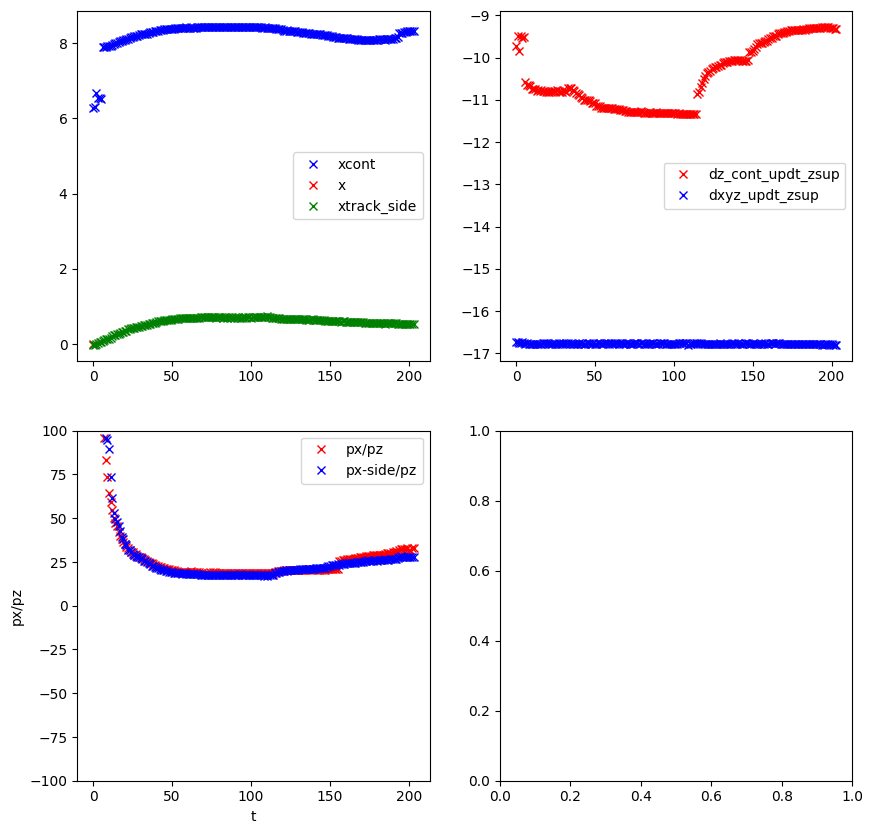

In [118]:
#%% check new variables
fig,ax = plt.subplots(2,2,figsize=(10,10)) 
k=20


ax[0][0].plot(events[k].x_cont_dec,'bx',label='xcont')
ax[0][0].plot(events[k].xyz[0][0],'rx',label='x')
ax[0][0].plot(events[k].x_track_side_dec,'gx',label='xtrack_side')
ax[0][0].legend()


ax[0][1].plot(events[k].dz_cont_updt_zsup,'rx',label='dz_cont_updt_zsup')
ax[0][1].plot(events[k].dxyz_updt_zsup[2][:],'bx',label='dxyz_updt_zsup')
ax[0][1].legend()
# ax[0][1].set_ylim(-3,3)

ax[1][0].set_xlabel('t')
ax[1][0].set_ylabel('px/pz')
ax[1][0].plot(events[k].px/events[k].pz,'rx',label='px/pz')
ax[1][0].plot(events[k].px_side/events[k].pz,'bx',label='px-side/pz')
ax[1][0].legend()
ax[1][0].set_ylim(-100,100)
# ax[1][0].set_xlim([-100,100])

# ax[1][1].plot(events[k].px_side/events[k].pz,'x')
# ax[1][1].set_xlabel('t')
# ax[1][1].set_ylabel('px-side/pz')
# ax[1][1].set_ylim(-3,3)
print(f'{events[k].p.pix2cm_s=}, {events[k].p.pix2cm_t=}')

Slip:False


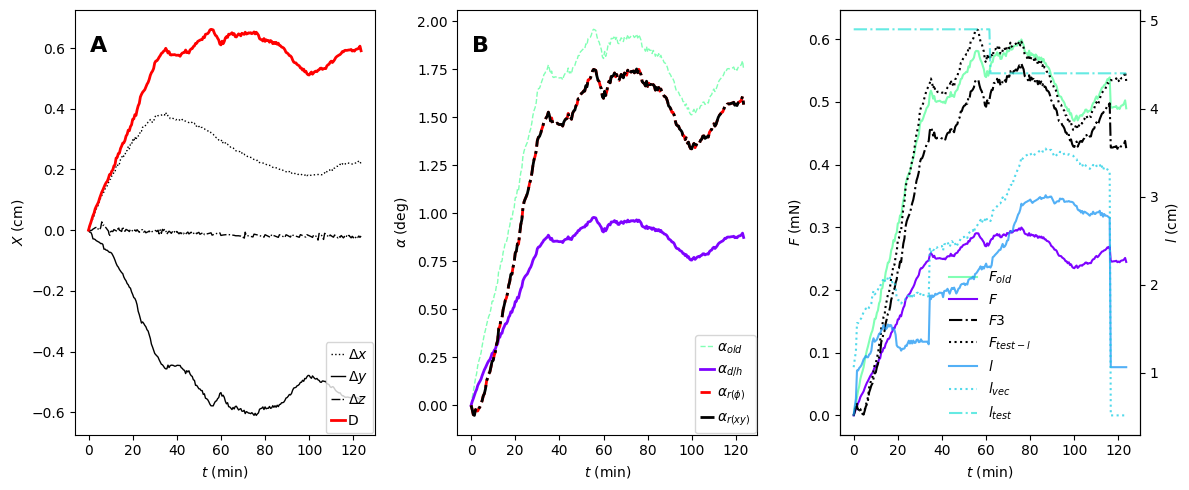

In [5]:
#%% figure - Force trajectory for slip event with contact position along support 2
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
fs= 16
i_slip = 89 # 40 (simple) , 20,120 (bump from dist2tip) , 70 = 79_2
test_ev = events[i_slip]
# check events are correctly classified
print("Slip:"+ str( test_ev.twine_state==0))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# Plot xyz coordinates
xyz = test_ev.xyz
axs[0].plot(test_ev.timer/60, xyz[0,::]-xyz[0,0], color='black', 
            linestyle = 'dotted', linewidth = 1, label=r'$\Delta x$') #cmap(0.1)
axs[0].plot(test_ev.timer/60, xyz[1,::]-xyz[1,0], color='black', 
            linestyle = '-', linewidth = 1, label=r'$\Delta y$') #cmap(0.5)
axs[0].plot(test_ev.timer/60, xyz[2,::]-xyz[2,0], color='black', 
            linestyle = 'dashdot', linewidth = 1, label=r'$\Delta z$') #cmap(0.9)
axs[0].plot(test_ev.timer/60, test_ev.trk_dist, color=cmap(1.5), linewidth = 2, label = 'D') #cmap(1.5)

# Plot angles
axs[1].plot(test_ev.timer/60, np.rad2deg(test_ev.alpha_old), 
          color=cmap(0.5),linestyle = 'dashed', linewidth = 1, label=r'$\alpha_{old}$') #cmap(0.3)
axs[1].plot(test_ev.timer/60, np.rad2deg(test_ev.alpha), 
          color=cmap(1), linewidth = 2, label=r'$\alpha_{d/h}$') #cmap(0.2)
axs[1].plot(test_ev.timer/60, np.rad2deg(test_ev.alpha2-test_ev.alpha2[0]), 
          color=cmap(1.5),linestyle = 'dashed', linewidth = 2, label=r'$\alpha_{r(\phi)}$') #cmap(0.3)
axs[1].plot(test_ev.timer/60, np.rad2deg(test_ev.alpha3), 
          color='k',linestyle = 'dashdot', linewidth = 2, label=r'$\alpha_{r(xy)}$') #cmap(0.3)

# add legend label from the twin axis
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs[1].get_legend_handles_labels()

# set axis and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
# uf.set_grid(axs[0],10,0.2)
# axs[0].set_ylim([-2,2])

axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$\alpha$ (deg)')
# uf.set_grid(axs[1],10,0.5)
# axs0.set_ylim([-6,6])

# axs0.set_ylim([-6,6])

# Adjust the legend properties

axs[0].legend(
    lines, labels,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)

axs[1].legend(
    lines2, labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)


###########################################
# Plot calculated force and contact position

axs[2].plot(test_ev.timer/60, test_ev.F_bean_old,
             color=cmap(0.5), label=r'$F_{old}$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean,
             color=cmap(1), label=r'$F$') 
# axs[2].plot(test_ev.timer/60, test_ev.F_bean_2,
#              color=cmap(1.5),linestyle = 'dashed', label=r'$F2$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_3,
             color='k',linestyle = 'dashdot', label=r'$F3$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_test_l,
             color='k',linestyle = 'dotted', label=r'$F_{test-l}$')
ax2 = axs[2].twinx()
dist2tip = [abs(k) for k in test_ev.L_contact2suptip]
lc_trig = [abs(k) for k in test_ev.l_c_trig]
lc_vec = [abs(k) for k in test_ev.l_c_vec]
l_test = [abs(k) for k in test_ev.test_lc]

# axs[2].vlines(test_ev.timer[-1]/60, 0, test_ev.F_bean[-1]*mg2mN,
#                color=cmap(1.5),)
ax2.plot(test_ev.timer/60, dist2tip, color= cmap(0.2),
          label=r'$l$', alpha=0.75)
# ax2.plot(test_ev.timer/60, lc_trig, color= cmap(0.25), linestyle='dashed',
#           label=r'$lc-trig$', alpha=0.75)
ax2.plot(test_ev.timer/60, test_ev.p.Lsup_cm-lc_vec, color= cmap(0.3), linestyle='dotted',
          label=r'$l_{vec}$', alpha=0.75)
ax2.plot(test_ev.timer/60, test_ev.p.Lsup_cm-l_test, color= cmap(0.35), linestyle='dashdot',
          label=r'$l_{test}$', alpha=0.75)

lines, labels = axs[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[2].legend(lines + lines2, labels + labels2, loc='best',frameon=False)

ax2.set_ylabel(r'$l$ (cm)')
# ax2.set_ylim([0,2])
axs[2].set_xlabel(r'$t$ (min)')
axs[2].set_ylabel(r'$F$ (mN)')
# uf.set_grid(axs[1],50,0.15)

plt.tight_layout()
plt.show()
# fig.savefig(save_folder+r'\xyz_ang_F_l_2.png',dpi=300)

Slip:False


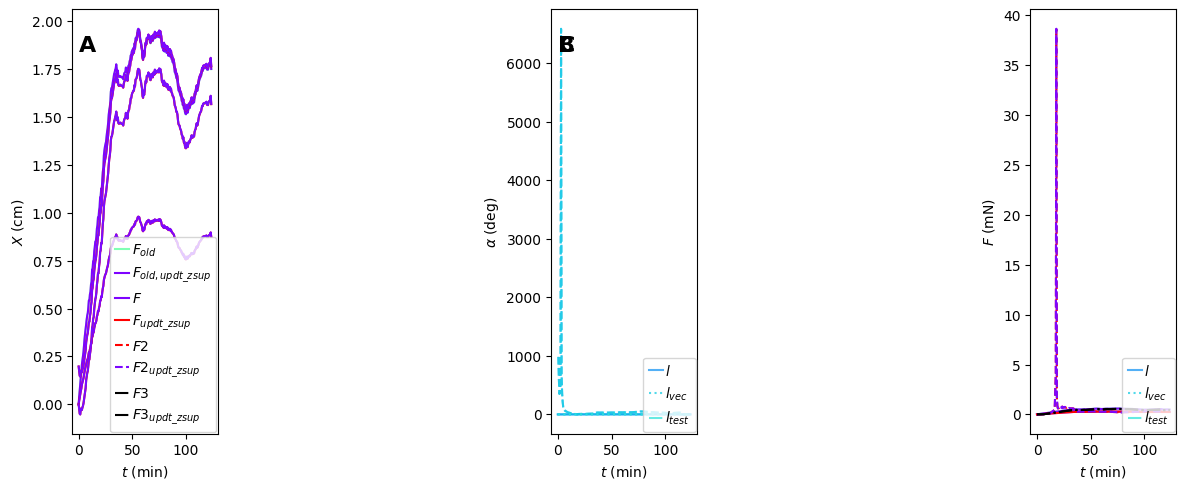

In [8]:
#%% figures - compare old to new calc methods
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
fs= 16
i_slip = 89 # 40 (simple) , 20,120 (bump from dist2tip) , 70 = 79_2
test_ev = events[i_slip]
# check events are correctly classified
print("Slip:"+ str( test_ev.twine_state==0))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)
axs[2].text(0.05, 0.9, 'C', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# Plot 
# F_bean_old, F_bean, F_bean_2, F_bean_3

# alpha_old, alpha, alpha2, alpha3
alpha_old = np.rad2deg(test_ev.alpha_old)
alpha_old_alpha_old_updt_zsup = np.rad2deg(test_ev.alpha_old_updt_zsup)
alpha = np.rad2deg(test_ev.alpha)
alpha_updt_zsup = np.rad2deg(test_ev.alpha_updt_zsup)
alpha2 = np.rad2deg(test_ev.alpha2)
alpha2_updt_zsup = np.rad2deg(test_ev.alpha2_updt_zsup)
alpha3 = np.rad2deg(test_ev.alpha3)
alpha3_updt_zsup = np.rad2deg(test_ev.alpha3_updt_zsup)

axs[0].plot(test_ev.timer/60, alpha_old, color=cmap(0.5), label=r'${alpha}_{old}$')
axs[0].plot(test_ev.timer/60, alpha_old_alpha_old_updt_zsup, color=cmap(1), label=r'${alpha}_{old,updt\_zsup}$')
axs[0].plot(test_ev.timer/60, alpha, color=cmap(1.5), label=r'${alpha}_{d/h}$')
axs[0].plot(test_ev.timer/60, alpha_updt_zsup, color=cmap(2), label=r'${alpha}_{d/h,updt\_zsup}$')
axs[0].plot(test_ev.timer/60, alpha2, color=cmap(2.5), label=r'${alpha}_{r(\phi)}$')
axs[0].plot(test_ev.timer/60, alpha2_updt_zsup, color=cmap(3), label=r'${alpha}_{r(\phi),updt\_zsup}$')
axs[0].plot(test_ev.timer/60, alpha3, color=cmap(3.5), label=r'${alpha}_{r(xy)}$')
axs[0].plot(test_ev.timer/60, alpha3_updt_zsup, color=cmap(4), label=r'${alpha}_{r(xy),updt\_zsup}$')

# contact2suptip, l_c_trig, l_c_vec
dist2tip = [abs(k) for k in test_ev.L_contact2suptip]
dist2tip_updt_zsup = [abs(k) for k in test_ev.L_contact2suptip_updt_zsup]
lc_trig = [abs(k) for k in test_ev.l_c_trig]
lc_trig_updt_zsup = [abs(k) for k in test_ev.l_c_trig_updt_zsup]
lc_vec = [abs(k) for k in test_ev.l_c_vec]
lc_vec_updt_zsup = [abs(k) for k in test_ev.l_c_vec_updt_zsup]


axs[1].plot(test_ev.timer/60, dist2tip, color= cmap(0.2),
          label=r'$l$', alpha=0.75)
axs[1].plot(test_ev.timer/60, dist2tip_updt_zsup, color= cmap(0.25),
          label=r'$l_{updt\_zsup}$', alpha=0.75)
axs[1].plot(test_ev.timer/60, lc_trig, color= cmap(0.25), linestyle='dashed',
          label=r'$lc-trig$', alpha=0.75)
axs[1].plot(test_ev.timer/60, lc_trig_updt_zsup, color= cmap(0.3), linestyle='dashed',
          label=r'$lc-trig_{updt\_zsup}$', alpha=0.75)
axs[1].plot(test_ev.timer/60, test_ev.p.Lsup_cm-lc_vec, color= cmap(0.3), linestyle='dotted',
          label=r'$l_{vec}$', alpha=0.75)
axs[1].plot(test_ev.timer/60, test_ev.p.Lsup_cm-lc_vec_updt_zsup, color= cmap(0.35), linestyle='dotted',
          label=r'$l_{vec_{updt\_zsup}}$', alpha=0.75)

# Plot calculated forces
F_bean = test_ev.F_bean
F_bean_2 = test_ev.F_bean_2
F_bean_3 = test_ev.F_bean_3
F_bean_updt_zsup = test_ev.F_bean_updt_zsup
F_bean_2_updt_zsup = test_ev.F_bean_2_updt_zsup
F_bean_3_updt_zsup = test_ev.F_bean_3_updt_zsup

axs[2].plot(test_ev.timer/60, test_ev.F_bean_old,
             color=cmap(0.5), label=r'$F_{old}$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_old_updt_zsup,
             color=cmap(1), label=r'$F_{old,updt\_zsup}$')
axs[2].plot(test_ev.timer/60, test_ev.F_bean,
             color=cmap(1), label=r'$F$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_updt_zsup,
             color=cmap(1.5), label=r'$F_{updt\_zsup}$')
axs[2].plot(test_ev.timer/60, test_ev.F_bean_2,
             color=cmap(1.5),linestyle = 'dashed', label=r'$F2$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_2_updt_zsup,
             color=cmap(2),linestyle = 'dashed', label=r'$F2_{updt\_zsup}$')
axs[2].plot(test_ev.timer/60, test_ev.F_bean_3,
             color='k',linestyle = 'dashdot', label=r'$F3$') 
axs[2].plot(test_ev.timer/60, test_ev.F_bean_3_updt_zsup,
             color='k',linestyle = 'dashdot', label=r'$F3_{updt\_zsup}$')




# add legend label from the twin axis
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs[1].get_legend_handles_labels()

# set axis and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
# uf.set_grid(axs[0],10,0.2)
# axs[0].set_ylim([-2,2])

axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$\alpha$ (deg)')
# uf.set_grid(axs[1],10,0.5)
# axs0.set_ylim([-6,6])

# axs0.set_ylim([-6,6])


lines, labels = axs[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[2].legend(lines + lines2, labels + labels2, loc='best',frameon=False)

ax2.set_ylabel(r'$l$ (cm)')
# ax2.set_ylim([0,2])
axs[2].set_xlabel(r'$t$ (min)')
axs[2].set_ylabel(r'$F$ (mN)')
# uf.set_grid(axs[1],50,0.15)


# Adjust the legend properties

axs[0].legend(
    lines, labels,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)

axs[1].legend(
    lines2, labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)
axs[2].legend(
    lines2, labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)

plt.tight_layout()
plt.show()
# fig.savefig(save_folder+r'\xyz_ang_F_l_2.png',dpi=300)

In [18]:
#%% tests
# plt.plot(test_ev.alpha2)
# plt.plot(test_ev.l_c_trig)
# plt.plot(test_ev.l_c_vec,'r')
# plt.plot(test_ev.xyz_contact[2])
# plt.plot(np.sqrt(test_ev.xyz_contact[0]**2+test_ev.xyz_contact[1]**2+test_ev.xyz_contact[2]**2))
print(test_ev.p.exp_num,test_ev.event_num)
# plt.plot(test_ev.dxyz[2],'b')
# plt.plot(test_ev.xyz[2],'b')
# plt.plot(test_ev.dz_cont,'r')
# print(test_ev.F_bean_3)
# plt.plot(test_ev.pz)
# plt.plot(test_ev.z_cont_dec)
# plt.plot(test_ev.z_cont)
# print(f'lengths of variables: {len(test_ev.pz)},{len(test_ev.dz_cont)},{len(test_ev.F_bean_3)},\
#       {len(test_ev.alpha2)},{len(test_ev.l_c_vec)}')
# plt.plot(test_ev.p.Lsup_cm,'x')
# plt.plot(test_ev.p.m_sup,'x')
# plt.plot(test_ev.z_cont_dec-test_ev.p.Lsup_cm)
# plt.plot(test_ev.xyz_contact[2])
# plt.plot(np.subtract(test_ev.xyz.T,test_ev.hinge).T[2])
print(f'{test_ev.z0_side=},{test_ev.p.support_base_z_pos_pix=}')
print(f'{test_ev.p.pix2cm_s=}')

print(f'{test_ev.L_tracked=},{test_ev.L_track2suptip_cm=}')
# print(f'{np.sqrt((test_ev.xyz[0]**2+test_ev.xyz[1]**2))=}')
# print(f'{test_ev.alpha2=}')

L_track2suptip = abs(test_ev.z0_side-test_ev.p.support_base_z_pos_pix)
L_track2suptip_cm = test_ev.L_track2suptip*test_ev.p.pix2cm_s

print(f'{test_ev.p.support_base_z_pos_pix=},{test_ev.z0_side=},{test_ev.p.pix2cm_s=},{L_track2suptip=},{L_track2suptip_cm=}')


74 1
test_ev.z0_side=1675.0,test_ev.p.support_base_z_pos_pix=1714.0
test_ev.p.pix2cm_s=0.013416815742397137
test_ev.L_tracked=-0.2562611806797853,test_ev.L_track2suptip_cm=0.5232558139534883
test_ev.p.support_base_z_pos_pix=1714.0,test_ev.z0_side=1675.0,test_ev.p.pix2cm_s=0.013416815742397137,L_track2suptip=39.0,L_track2suptip_cm=0.5232558139534883


ev.p.exp_num=36,ev.event_num=1,ev.twine_state=1.0,L_track2suptip=440.0,L_track2suptip_cm=3.13986684
ev.p.exp_num=40,ev.event_num=1,ev.twine_state=1.0,L_track2suptip=454.0,L_track2suptip_cm=3.3357196
ev.p.exp_num=41,ev.event_num=1,ev.twine_state=0.0,L_track2suptip=417.5,L_track2suptip_cm=3.010817115
ev.p.exp_num=41,ev.event_num=2,ev.twine_state=0.0,L_track2suptip=408.5,L_track2suptip_cm=2.945913273
ev.p.exp_num=44,ev.event_num=1,ev.twine_state=1.0,L_track2suptip=351.0,L_track2suptip_cm=4.2323151779999995
ev.p.exp_num=46,ev.event_num=1,ev.twine_state=0.0,L_track2suptip=435.0,L_track2suptip_cm=3.595041405
ev.p.exp_num=46,ev.event_num=2,ev.twine_state=1.0,L_track2suptip=420.5,L_track2suptip_cm=3.4752066915
ev.p.exp_num=47,ev.event_num=1,ev.twine_state=1.0,L_track2suptip=104.0,L_track2suptip_cm=1.17735852
ev.p.exp_num=59,ev.event_num=1,ev.twine_state=0.0,L_track2suptip=170.0,L_track2suptip_cm=1.7857143400000002
ev.p.exp_num=61,ev.event_num=1,ev.twine_state=1.0,L_track2suptip=425.0,L_track2s

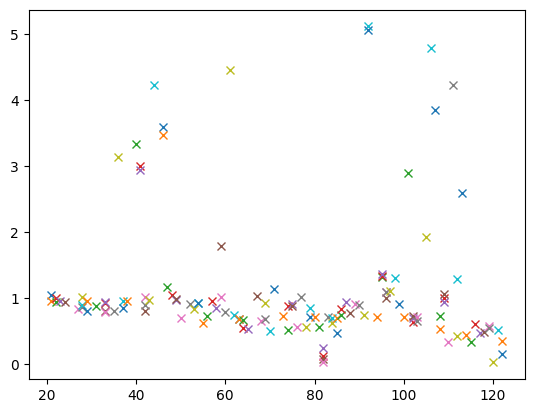

In [8]:
# look at all distances between track and support bottom tip
plt.figure()
for i in range(len(events)):
    ev = events[i]
    exp_num = ev.p.exp_num
    L_track2suptip = abs(ev.z0_side-ev.p.support_base_z_pos_pix)
    L_track2suptip_cm = ev.L_track2suptip*ev.p.pix2cm_s
    # print(f'{ev.p.exp_num=},{ev.event_num=},{ev.twine_state=},{L_track2suptip=},{L_track2suptip_cm=}')
    plt.plot(exp_num,L_track2suptip_cm,'x')
    # save a list of all events with L_track2suptip_cm>1
    if L_track2suptip_cm>1.1:
        print(f'{ev.p.exp_num=},{ev.event_num=},{ev.twine_state=},{L_track2suptip=},{L_track2suptip_cm=}')


y_supp_base-y_track=-425.0,events[i].p.pix2cm_s=0.010504202


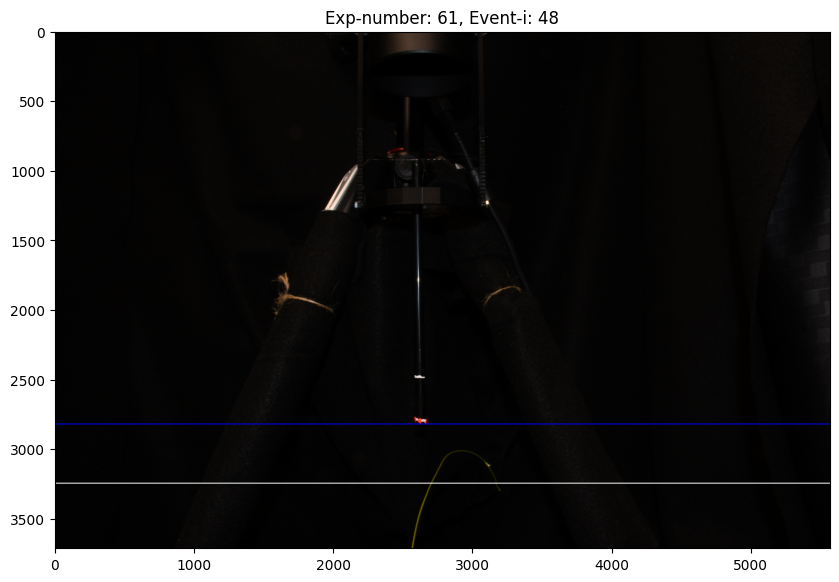

img_init.shape=(3712, 5568, 3)


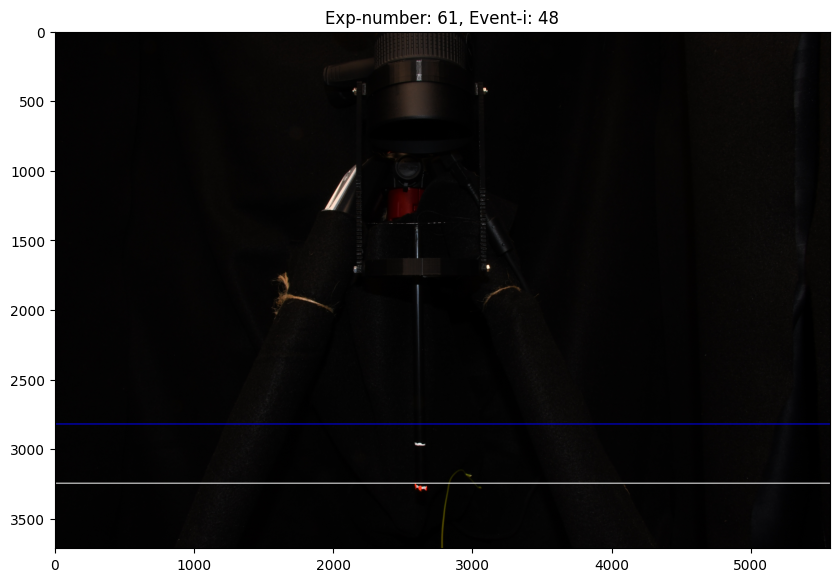

img_tracked.shape=(3712, 5568, 3)


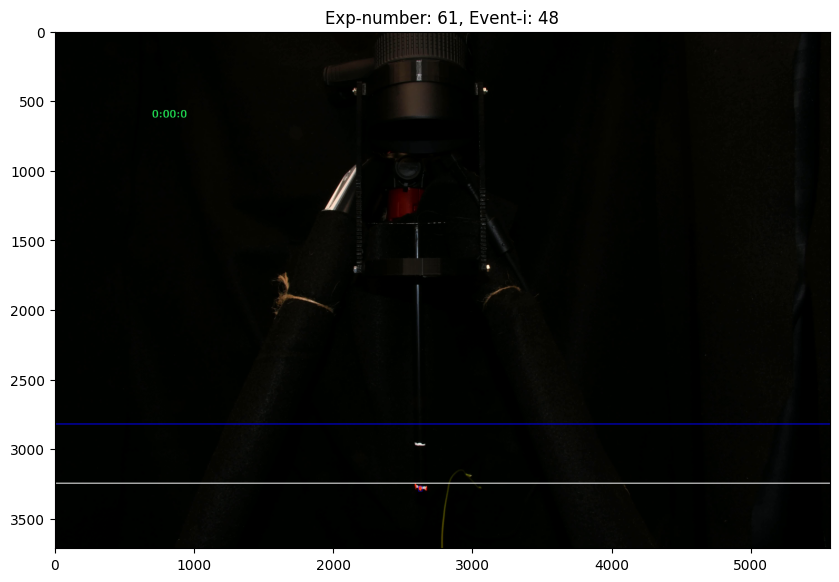

In [ ]:
# for each file in the list, show the image from the init photos, 
# and mark a line on the image showing the y position of the supposed bottom of the support
# try on one first
import cv2
file = r"C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\minsc_photos\initial\061_side.JPG"
# find exp and event num:
exp = 61
ev = 1
for i in range(len(events)):
    if events[i].p.exp_num==exp and events[i].event_num==ev:
        ev = i
        break
img_init = cv2.imread(file)
y_supp_base = events[i].p.support_base_z_pos_pix
y_track = events[i].z0_side
print(f'{y_supp_base-y_track=},{events[i].p.pix2cm_s=}')
import matplotlib.pyplot as plt

# Draw the line on the image
cv2.line(img_init, (0, int(y_supp_base)), (img_init.shape[1], int(y_supp_base)), (255, 0, 0), 5)
cv2.line(img_init, (0, int(y_track)), (img_init.shape[1], int(y_track)), (255, 255, 255), 5)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_init, cv2.COLOR_BGR2RGB))
plt.title(f'Exp-number: {exp}, Event-i: {ev}')
plt.show()

print(f'{img_init.shape=}')

# get 1st frame from tracked files
img_tracked_path = r"C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\61\Side\1\DSC_9860.JPG"
img_tracked = cv2.imread(img_tracked_path)
# Draw the line on the image
cv2.line(img_tracked, (0, int(y_supp_base)), (img_tracked.shape[1], int(y_supp_base)), (255, 0, 0), 5)
cv2.line(img_tracked, (0, int(y_track)), (img_tracked.shape[1], int(y_track)), (255, 255, 255), 5)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_tracked, cv2.COLOR_BGR2RGB))
plt.title(f'Exp-number: {exp}, Event-i: {ev}')
plt.show()

print(f'{img_tracked.shape=}')

# get 1st frame from tracked video
vid_path = r"C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\61\Side\CSRT_061_1\1.avi"
cap = cv2.VideoCapture(vid_path)
ret, vid_frame = cap.read()
# Draw the line on the image
cv2.line(vid_frame, (0, int(y_supp_base)), (vid_frame.shape[1], int(y_supp_base)), (255, 0, 0), 5)
cv2.line(vid_frame, (0, int(y_track)), (vid_frame.shape[1], int(y_track)), (255, 255, 255), 5)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vid_frame, cv2.COLOR_BGR2RGB))
plt.title(f'Exp-number: {exp}, Event-i: {ev}')
plt.show()

print(f'{vid_frame.shape=}')

exp_num=21,ev_num=1,L_track2suptip=91.0,L_track2suptip_cm=1.0427807390000001
C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\\21\\Side\\CSRT_021_1
mark First Frame
exp_num=22,ev_num=1,L_track2suptip=91.0,L_track2suptip_cm=1.0427807390000001
C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\\22\\Side\\CSRT_022_1
mark First Frame
exp_num=23,ev_num=1,L_track2suptip=91.0,L_track2suptip_cm=1.0427807390000001
C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\\23\\Side\\CSRT_023_1
mark First Frame
exp_num=24,ev_num=1,L_track2suptip=91.0,L_track2suptip_cm=1.0427807390000001
C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\\24\\Side\\CSRT_024_1
mark First Frame
exp_num=27,ev_num=1,L_track2suptip=91.0,L_track2suptip_cm=1.0427807390000001
C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements\\27\\Side\\CSRT_027_1
mark Fi

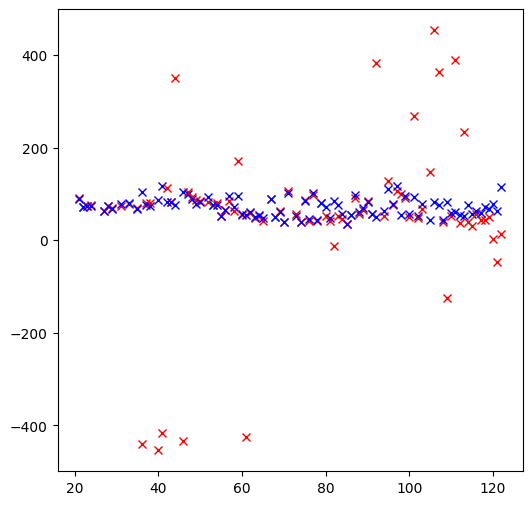

In [ ]:
# for each experiment in the list, open the first frame in the tracked folder, allow a ROI to mark the support bottom, extract the center of the ROI
# and save the y position of the center of the ROI
# look at all distances between track and support bottom tip
# start dictionary to save the old and new y coordinates
import cv2

# Check if y_dict exists, if not create it
if 'y_dict'  in globals():
    response = input("y_dict already exists. Do you want to continue or stop? (continue/stop): ")
    if response.lower() == 'stop':
        raise SystemExit("Execution stopped by user.")
y_dict = {}
plt.figure(figsize=(6,6))
base_path = r"C:\Users\Amir\Documents\PHD\Experiments\Force Measurements\Exp2_Pendulum\Measurements"
ev = events[0]
exp_num = events[0].p.exp_num
for i in range(len(events)): 
    # save a list of all events data
    if events[i].p.exp_num == exp_num and len(y_dict)>0: 
        ev_num = events[i].event_num
        ev = events[i]
        exp_num = ev.p.exp_num
        ev_num = ev.event_num
        y_dict[exp_num,ev_num,'old_y_supp_base'] = ev.p.support_base_z_pos_pix
        y_dict[exp_num,ev_num,'y_track'] = ev.z0_side
        # Check if there is a previous event with the same exp_num
        previous_event_key = next((key for key in y_dict.keys() if key[0] == exp_num), None)
        if previous_event_key:
            y_dict[exp_num, ev_num, 'new_supp_bot'] = y_dict[previous_event_key[0], previous_event_key[1], 'new_supp_bot']
        else:
            y_dict[exp_num, ev_num, 'new_supp_bot'] = y_dict[exp_num, ev_num, 'old_y_supp_base']
    else:
        ev = events[i]
        exp_num = ev.p.exp_num
        ev_num = ev.event_num
        y_dict[exp_num,ev_num,'old_y_supp_base'] = ev.p.support_base_z_pos_pix
        y_dict[exp_num,ev_num,'y_track'] = ev.z0_side
        print(f'{exp_num=},{ev_num=},{L_track2suptip=},{L_track2suptip_cm=}')
        # get 1st frame from tracked video
        # \61\Side\CSRT_061_1\1.avi
        vid_folder = base_path+fr'\\{exp_num}\\Side\\CSRT_0{exp_num}_{ev_num}'
        print(vid_folder)
        vid_path = glob.glob(os.path.join(vid_folder, '*.avi'))[0]
        cap = cv2.VideoCapture(vid_path)
        ret, vid_frame = cap.read()
        # Display the first frame with the ROI for the support bottom
        if np.shape(vid_frame):
            y_dict[exp_num,ev_num,'new_supp_bot'] = uf.ROIcenter(vid_frame,'First Frame')[1]
        else:
            print('no img', exp_num, ev_num,vid_path)
    
        # save to dict
        old_diff = y_dict[exp_num,ev_num,'old_y_supp_base']-y_dict[exp_num,ev_num,'y_track']
        new_diff = y_dict[exp_num,ev_num,'new_supp_bot']-y_dict[exp_num,ev_num,'y_track']

        plt.plot(exp_num,old_diff,'rx')
        plt.plot(exp_num,new_diff,'bx')
# print(y_dict)


In [93]:
# to close all open windows from crash
# cv2.destroyAllWindows()

# print(y_dict)

# plot the differences
# plt.figure(figsize=(6,6))
# for key in y_dict.keys():
#     old_diff = y_dict[key[0],'old_y_supp_base'] - y_dict[key[0],'y_track']
#     new_diff = y_dict[key[0],'new_supp_bot'] - y_dict[key[0],'y_track']
#     plt.plot(key[0], old_diff, 'rx')
#     plt.plot(key[0], new_diff, 'bx')
# plt.legend(['old', 'new'])

# create new dictionary with only the new y values
# y_new = [y_dict[key[0],'new_supp_bot'] for key in y_dict.keys()]
y_dict.keys()
# check if exp_num is in the dictionary
# exp_num = 22
# if next((key for key in y_dict.keys() if key[0] == exp_num), None):
#     print('there')

y_new = {}
for key in y_dict.keys():
    y_new[key[0],key[1],'side'] = y_dict[key[0],key[1],'new_supp_bot']
    y_new[key[0],key[1],'top'] = y_dict[key[0],key[1],'new_supp_bot']

print(y_new)
# y_new.keys()

{(21, 1, 'side'): 1268, (21, 1, 'top'): 1268, (21, 2, 'side'): 1268, (21, 2, 'top'): 1268, (22, 1, 'side'): 1269, (22, 1, 'top'): 1269, (22, 2, 'side'): 1269, (22, 2, 'top'): 1269, (23, 1, 'side'): 1276, (23, 1, 'top'): 1276, (24, 1, 'side'): 1272, (24, 1, 'top'): 1272, (27, 1, 'side'): 1276, (27, 1, 'top'): 1276, (28, 1, 'side'): 1269, (28, 1, 'top'): 1269, (28, 2, 'side'): 1269, (28, 2, 'top'): 1269, (28, 3, 'side'): 1269, (28, 3, 'top'): 1269, (29, 1, 'side'): 1293, (29, 1, 'top'): 1293, (29, 2, 'side'): 1293, (29, 2, 'top'): 1293, (31, 1, 'side'): 1296, (31, 1, 'top'): 1296, (33, 1, 'side'): 1294, (33, 1, 'top'): 1294, (33, 2, 'side'): 1294, (33, 2, 'top'): 1294, (33, 3, 'side'): 1294, (33, 3, 'top'): 1294, (33, 4, 'side'): 1294, (33, 4, 'top'): 1294, (35, 1, 'side'): 1291, (35, 1, 'top'): 1291, (36, 1, 'side'): 2955, (36, 1, 'top'): 2955, (37, 1, 'side'): 1292, (37, 1, 'top'): 1292, (37, 3, 'side'): 1292, (37, 3, 'top'): 1292, (38, 1, 'side'): 1290, (38, 1, 'top'): 1290, (40, 1, '